# Projeto 2 - Ciência dos Dados

• Alunos: Gustavo Guedes, Maia Fleider, Natália Carreras e Tiago Seixas. 

## > Introdução

### ❑ Objetivos e detalhes da base de dados:

▶ O objetivo geral de nosso projeto é realizar um **modelo de predição** de **níveis de radiação solar**. Nesse sentido, analisamos também como outras features (umidade e temperatura, por exemplo) influenciam o comportamento da varíavel. Para a realização do projeto, utlizamos uma base de dados fornecida a participantes da NASA Hackathon (Space Apps Moscow).

▶ A base de dados foi produzida através de dados metereológicos retirados, ao longo de meses, da estação HI-SEAS, localizada no Havaí, Estados Unidos.

<ol>• Para mais detalhes, acesse: 
<li> Kaggle (base de dados): <a href="https://www.kaggle.com/dronio/SolarEnergy" > Solar Radiation </a> </li>
</ol>

<img src="img/painelsolar.jpg" width=550>

## > Minerando Dados e Características do Dataset

In [1]:
#Importando biblotecas úteis:

%matplotlib inline
from sklearn.utils import shuffle
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import os
import re 
import statsmodels.api as sm

### ❑ Filtros e leitura do Dataset: 

In [2]:
#Iniciando leitura de dados:
raw_data = pd.read_csv('SolarPrediction.csv')
raw_data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
#Filtrando colunas que serão relevantes para futura análise:
dados = raw_data.loc[:,['UNIXTime','Data','Time','Radiation','Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
dados.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62


In [4]:
#Aplicando funções de filtro e definindo funções auxiliáres:

def cleanup(text):
    punctuation = '[/]' 
    frase = '12:00:00 AM'
    
    pattern = re.compile(punctuation)
    pattern2 = re.compile(frase)
    
    text_subbed = re.sub(pattern, '-', text)
    text_subbed = re.sub(pattern2, '', text)
    
    return text_subbed

def converte_temp(temp):
    graus = ((temp-32)*5)/9
    return graus

def calcula_radiacao(df):
    return df.loc[:, ["Mes", "Radiacao"]].groupby(by="Mes").mean()

def milhas_km(veloc):
    vel = veloc*1.609
    return vel

def hg_atm(hg):
    atm = hg/29,921
    return atm


In [5]:
#Aplicando filtro, somente (Trocando '/' por '-' para usar propriedades da biblioteca pandas).
dados.Data = dados.Data.apply(cleanup)

In [6]:
dados.Data.tail()

32681    12/1/2016 
32682    12/1/2016 
32683    12/1/2016 
32684    12/1/2016 
32685    12/1/2016 
Name: Data, dtype: object

In [7]:
pd.to_datetime("12/1/2016", format="%m/%d/%Y")

Timestamp('2016-12-01 00:00:00')

In [32]:
#Organizando Data (repare que invertemos a ordem, agora está ano-mes-dia)
dados.Data = pd.to_datetime(dados.Data, yearfirst=True)
dados.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Year,Month,Day
0,1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62,2016,9,29
1,1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37,2016,9,29
2,1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37,2016,9,29
3,1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37,2016,9,29
4,1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62,2016,9,29


In [9]:
#Adicionando colunas de tempo para o dataframe
dados['Year'] = dados['Data'].dt.year
dados['Month'] = dados['Data'].dt.month
dados['Day'] = dados['Data'].dt.day

#Apagando a coluna Data, já que separamos ela
dados_novo = dados.loc[:,['Day','Month','Year','Time','Radiation','Temperature','Pressure',
                          'Humidity','WindDirection(Degrees)','Speed']]

dados_novo.head(5)

,Day,Month,Year,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,29,9,2016,23:55:26,1.21,48,30.46,59,177.39,5.62
1,29,9,2016,23:50:23,1.21,48,30.46,58,176.78,3.37
2,29,9,2016,23:45:26,1.23,48,30.46,57,158.75,3.37
3,29,9,2016,23:40:21,1.21,48,30.46,60,137.71,3.37
4,29,9,2016,23:35:24,1.17,48,30.46,62,104.95,5.62


In [10]:
#Realizados os ajustes, como estamos no Brasil, vamos traduzir e mudar unidades, visando a familiaridade.

dados_novo = dados_novo.rename(columns={"Day": "Dia", "Month": "Mes", "Year":"Ano", "Time":"Hora", 
                                        "Radiation":"Radiacao", "Temperature":"Temperatura", 
                                        "Pressure":"Pressao", "Humidity":"Umidade", "WindDirection(Degrees)":"DirVento",
                                        "Speed":"VelocidadeVento"})

In [37]:
#Aplicando mudanças de unidades:

#Fahrenheit para Graus
dados_novo["TempGraus"] = dados_novo.Temperatura.apply(converte_temp)

#Milhas por hora para km/h
dados_novo["Velocidade"] = dados_novo.VelocidadeVento.apply(milhas_km)

#Hg para atm
dados_novo["Pressao(atm)"] = dados_novo.Pressao.apply(hg_atm)

dados_novo.head(5)

,Dia,Mes,Ano,Hora,Radiacao,Temperatura,Pressao,Umidade,DirVento,VelocidadeVento,TempGraus,Velocidade,Pressao(atm)
0,29,9,2016,23:55:26,1.21,48,30.46,59,177.39,5.62,8.888889,9.04258,"(1.0503448275862068, 921)"
1,29,9,2016,23:50:23,1.21,48,30.46,58,176.78,3.37,8.888889,5.42233,"(1.0503448275862068, 921)"
2,29,9,2016,23:45:26,1.23,48,30.46,57,158.75,3.37,8.888889,5.42233,"(1.0503448275862068, 921)"
3,29,9,2016,23:40:21,1.21,48,30.46,60,137.71,3.37,8.888889,5.42233,"(1.0503448275862068, 921)"
4,29,9,2016,23:35:24,1.17,48,30.46,62,104.95,5.62,8.888889,9.04258,"(1.0503448275862068, 921)"


In [12]:
#Realizando nova filtragem e organizando:
dataframe = dados_novo.loc[:,['Dia','Mes','Ano','Hora','Radiacao','TempGraus',
                        'Pressao(atm)','Umidade','DirVento','Velocidade']]
dataframe.head(5)

,Dia,Mes,Ano,Hora,Radiacao,TempGraus,Pressao(atm),Umidade,DirVento,Velocidade
0,29,9,2016,23:55:26,1.21,8.888889,"(1.0503448275862068, 921)",59,177.39,9.04258
1,29,9,2016,23:50:23,1.21,8.888889,"(1.0503448275862068, 921)",58,176.78,5.42233
2,29,9,2016,23:45:26,1.23,8.888889,"(1.0503448275862068, 921)",57,158.75,5.42233
3,29,9,2016,23:40:21,1.21,8.888889,"(1.0503448275862068, 921)",60,137.71,5.42233
4,29,9,2016,23:35:24,1.17,8.888889,"(1.0503448275862068, 921)",62,104.95,9.04258


### ❑ Descrição de variáveis e análise descritiva:

▶ As unidades das colunas de cada dataset são:


Variável | Descrição
:---:|---:
Radiação Solar | Unidade: $W/m^2$
Temperatura| Temperatura do ar (°C)
Pressao | Pressão Atmosférica (atm)
Umidade | Umidade Relativa do ar (%)
Direcao do Vento | Medido em Graus (°)
Velocidade do Vento | Medido em (km/h)

In [13]:
#Visão geral:
dataframe.describe()

,Dia,Mes,Ano,Radiacao,TempGraus,Umidade,DirVento,Velocidade
count,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,15.825766,10.526066,2016.0,207.124697,10.612920,75.016307,143.489821,10.046386
std,8.711824,1.096691,0.0,315.916387,3.445087,25.990219,83.167500,5.616172
min,1.000000,9.000000,2016.0,1.110000,1.111111,8.000000,0.090000,0.000000
25%,9.000000,10.000000,2016.0,1.230000,7.777778,56.000000,82.227500,5.422330
50%,16.000000,11.000000,2016.0,2.660000,10.000000,85.000000,147.700000,9.042580
75%,23.000000,11.000000,2016.0,354.235000,12.777778,97.000000,179.310000,12.662830
max,31.000000,12.000000,2016.0,1601.260000,21.666667,103.000000,359.950000,65.164500


In [14]:
#Contando meses (São quatro meses): 
dataframe.Mes.min(), dataframe.Mes.max()

(9, 12)

In [15]:
lista_rad = calcula_radiacao(dataframe)
lista_rad.head(5)

,Radiacao
Mes,
9,229.804828
10,230.582292
11,226.727750
12,141.283240


<Figure size 1008x576 with 0 Axes>

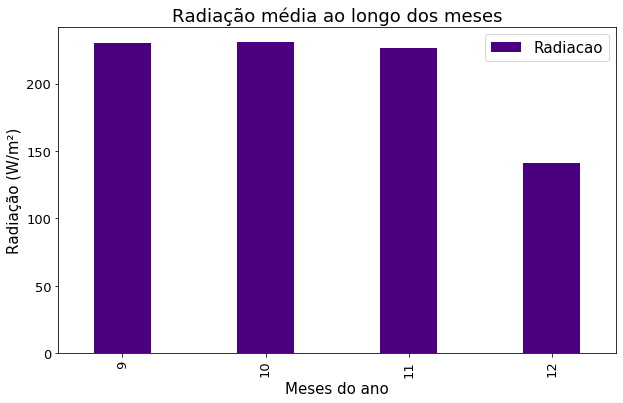

In [16]:
#Radiação média ao longo dos meses (Setembro até Dezembro)

plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 15})
lista_rad.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13, width=0.4);
plt.title("Radiação média ao longo dos meses")
plt.xlabel("Meses do ano")
plt.ylabel("Radiação (W/m²)")
plt.legend()
plt.show()


In [39]:
#Radiação em um dia 
filtro_dia = dataframe.loc[:,'Dia'] == 12
filtro_mes = dataframe.loc[:,'Mes'] == 10

dia = dataframe.loc[filtro_dia & filtro_mes, ['Radiacao','Hora']]
dia.head(5)

,Radiacao,Hora
12849,1.25,23:55:23
12850,1.25,23:50:21
12851,1.25,23:45:25
12852,1.26,23:40:28
12853,1.23,23:35:22


In [40]:
dia["Hora"] = pd.to_datetime(dia['Hora']).dt.time
dia.head(5)

,Radiacao,Hora
12849,1.25,23:55:23
12850,1.25,23:50:21
12851,1.25,23:45:25
12852,1.26,23:40:28
12853,1.23,23:35:22


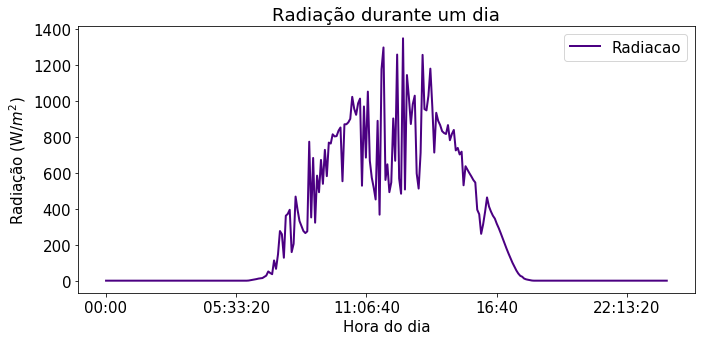

In [41]:
#Plotando o gráfico:

plt.figure(figsize=(10,5))
plt.plot(dia.Hora,dia.Radiacao, label='Radiacao', color='indigo', linewidth=2) 
plt.title("Radiação durante um dia")
plt.xlabel("Hora do dia")
plt.ylabel("Radiação (W/$m^2$)")
plt.legend()
plt.tight_layout()
plt.show()

### ❑ Análises mais gerais dos dados via heatmap:

In [42]:
#Fazendo um "pequeno" filtro para uma análise melhor dos dados, ou seja, pegando só variáveis quantitativas importantes:
heat = dataframe.loc[:,['Radiacao','Hora','TempGraus',
                        'Pressao(atm)','Umidade','DirVento','Velocidade']]
heat.head(5)

,Radiacao,Hora,TempGraus,Pressao(atm),Umidade,DirVento,Velocidade
0,1.21,23:55:26,8.888889,"(1.0503448275862068, 921)",59,177.39,9.04258
1,1.21,23:50:23,8.888889,"(1.0503448275862068, 921)",58,176.78,5.42233
2,1.23,23:45:26,8.888889,"(1.0503448275862068, 921)",57,158.75,5.42233
3,1.21,23:40:21,8.888889,"(1.0503448275862068, 921)",60,137.71,5.42233
4,1.17,23:35:24,8.888889,"(1.0503448275862068, 921)",62,104.95,9.04258


#### ▶ Pairplot:

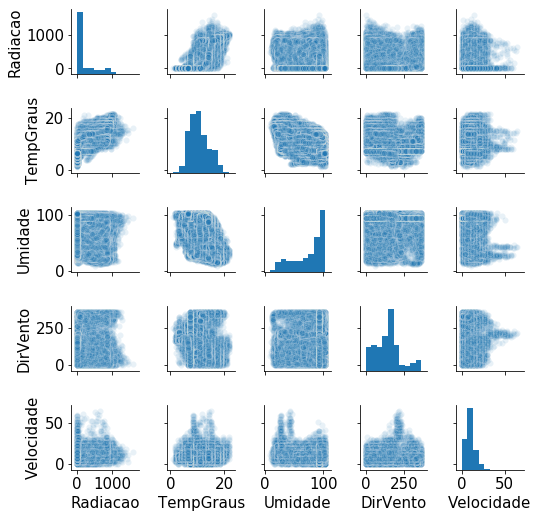

In [43]:
sns.pairplot(heat, height=1.5, plot_kws={'alpha':0.1});

#### ▶ Heatmap:

(5.0, 0.0)

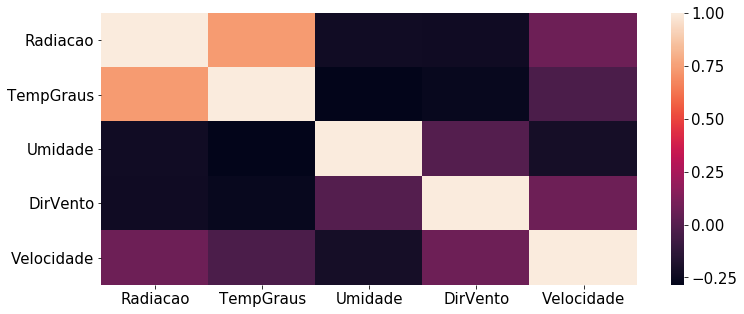

In [44]:
#Calcula coeficientes de correlação (matriz):
corr = heat.corr()

#Plotando mapa de calor e fazendo alguns ajustes 
plt.figure(figsize = (12,5))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
baixo, topo = ax.get_ylim()
ax.set_ylim(baixo + 0.5, topo - 0.5)

▶ O pairplot fornece uma visão geral dos dados, assim como o heatmap. A única diferença é na visualização dos dados (por scatter, ou por cores). 

▶ O heatmap analisa os coeficientes de correlação juntamente com cores, ou seja, o quão uma variável se relaciona/depende da outra. Nesse sentido, cores mais claras indicam relação entre as colunas. Por sua vez, cores mais escuras indicam que as colunas não tem muita relação! 

▶ No caso , como nosso projeto visa **prever a radiação**, ela é a **variável que importa** relacionada a **outras features**. Isso é uma informação que será útil para os futuros modelos. Veja que, por exemplo, Radiação e Temperatura são as duas colunas que mais estão relacionadas do que algumas outras. Então a ideia dos modelos abaixo é entender qual o melhor modelo que encaixa a variável target, com a feature!

## > Modelos de Predição 

In [45]:
#Usando comando shuffle para fazer uma separação de forma aleatória (base testes e treino)
dados2 = shuffle(heat).copy()
dados2.head(3)

,Radiacao,Hora,TempGraus,Pressao(atm),Umidade,DirVento,Velocidade
1982,1.26,22:40:20,12.222222,"(1.0503448275862068, 921)",85,118.05,3.62025
31862,1.23,20:35:34,7.222222,"(1.0462068965517242, 921)",93,284.92,3.62025
15090,1.23,01:45:24,10.000000,"(1.0496551724137932, 921)",102,141.76,7.24050


In [46]:
dados2.shape

(32686, 7)

In [47]:
#Iniciando processo de separação de dados:
train = dados2.iloc[0:16343,]
train.shape

(16343, 7)

In [48]:
train.head(5)

,Radiacao,Hora,TempGraus,Pressao(atm),Umidade,DirVento,Velocidade
1982,1.26,22:40:20,12.222222,"(1.0503448275862068, 921)",85,118.05,3.62025
31862,1.23,20:35:34,7.222222,"(1.0462068965517242, 921)",93,284.92,3.62025
15090,1.23,01:45:24,10.000000,"(1.0496551724137932, 921)",102,141.76,7.24050
10461,177.02,09:30:18,10.000000,"(1.0503448275862068, 921)",102,65.05,16.28308
18135,1.19,04:45:05,5.000000,"(1.0479310344827586, 921)",87,157.88,16.28308


In [49]:
test = dados2.iloc[16343:,]
test.shape

(16343, 7)

In [50]:
test.head(5)

,Radiacao,Hora,TempGraus,Pressao(atm),Umidade,DirVento,Velocidade
19700,1.24,18:15:18,12.222222,"(1.0489655172413794, 921)",19,151.37,5.42233
13489,9.89,17:55:20,13.888889,"(1.0482758620689654, 921)",78,141.88,5.42233
18067,770.09,10:25:05,11.111111,"(1.05, 921)",89,349.15,10.86075
12238,1.22,04:15:19,10.000000,"(1.0503448275862068, 921)",25,187.62,12.66283
11465,1.26,21:50:18,11.666667,"(1.0510344827586207, 921)",100,144.02,7.24050


### ❑ Descrição e aplicação do Modelo 1 (Treinamento) e validação (Teste):

#### ❑ Aplicação:

▶ O heatmap e o pairplot acima indicam que a radiação tem relação com a temperatura. Pelo pairplot suspeitamos que seja possível aproximar linearmente essas duas variáveis, e por enquanto, faremos uma análise delas duas.

(Descrição do modelo, ver aula de regressão simples)

In [51]:
#Iniciando código do modelo de regressão simples

x_dados = train['TempGraus'] # Definindo Temperatura como explicativa
y_dados = train['Radiacao']    # Definindo Radiacao como resposta

# Matriz de 1s e valores de x_dados
X_dados = sm.add_constant(x_dados.values) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados)

In [52]:
# Define o modelo
model = sm.OLS(y_dados, X_dados)    

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Radiacao   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                 1.866e+04
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:23:53   Log-Likelihood:            -1.1093e+05
No. Observations:               16343   AIC:                         2.219e+05
Df Residuals:                   16341   BIC:                         2.219e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -502.8857      5.452    -92.231      0.000    -513.573    -492.198
x1            66.8298      0.489    136.616      0.000      65.871      67.789
==============================================================================
Omnibus:                     1228.012   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1619.395
Skew:                           0.665   Prob(JB):                         0.00
Kurtosis:                       3.781   Cond. No.                         36.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ❑ Análises:

#### ❑ Validação:

### ❑ Descrição e aplicação do Modelo 2 (Treinamento) e validação (Teste):

(Descrição do modelo 2 e justificativa)

#### ❑ Aplicação:

#### ❑ Análises:

#### ❑ Validação:

## > Conclusão 

## > Referências Bibliográficas 